In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier

import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

In [7]:
# show all version of packages and python
import sys
print("Python Version: " + sys.version)

from sklearn import __version__
print("sklearn Version: " + __version__)
from matplotlib import __version__
print("matplotlib Version: " + __version__)
print("numpy Version: " + np.__version__)
print("pandas Version: " + pd.__version__)

Python Version: 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]
sklearn Version: 1.4.0
matplotlib Version: 3.5.1
numpy Version: 1.22.2
pandas Version: 1.4.1



# Weather Prediction on Data Set by DWD
For legal issues about the origin of the data see https://www.dwd.de/DE/leistungen/opendata/opendata.html;jsessionid=EE8FF75EEE47BBD59C6A1EDBAF2313DD.live11054?nn=17308.

We use the historic data set and curate it first.

Code adapted from https://www.kaggle.com/code/mujtabamatin/skyinsight-weather-classifier released under the Appache License 2.0 https://www.apache.org/licenses/LICENSE-2.0

## Data Curation

In [8]:
data = pd.read_csv("___PUT FILE NAME___", sep=";")
data.head()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,5792,19000801,-999,-999.0,-999.0,5,-999.0,-999,15.0,-999,0.0,3.9,715.3,2.0,50.0,6.2,-3.6,-999,eor
1,5792,19000802,-999,-999.0,-999.0,5,-999.0,-999,6.2,-999,5.0,8.3,713.7,5.7,88.0,12.6,2.2,-999,eor
2,5792,19000803,-999,-999.0,-999.0,5,-999.0,-999,1.3,-999,8.0,7.9,710.6,3.6,96.0,7.9,1.2,-999,eor
3,5792,19000804,-999,-999.0,-999.0,5,-999.0,-999,0.0,-999,8.0,6.3,706.3,0.6,98.0,5.2,-2.8,-999,eor
4,5792,19000805,-999,-999.0,-999.0,5,-999.0,-999,0.0,-999,8.0,4.4,705.9,-3.9,95.0,-0.9,-5.4,-999,eor


In [9]:
# delete all data before year 2000
data = data[data["MESS_DATUM"] > 20000000]
# rename columns
data = data.rename(columns={"  PM": "Air Pressure", " RSK": "Precipitation Height", " SDK": "Sunshine Hours", " TMK": "Temperature Average", " TXK": "Maximum Temperature", " TNK": "Minimum Temperature", " UPM": "Relative Humidity"})
# delete some columns
data = data.drop(["STATIONS_ID", "eor", " TGK", "QN_3", "  FX", "  FM", "QN_4", "RSKF", "  NM", " VPM", "SHK_TAG"], axis=1)

In [10]:
data = data.replace(-999,np.nan)
data.isna().sum()

MESS_DATUM               0
Precipitation Height     2
Sunshine Hours           0
Air Pressure             3
Temperature Average      0
Relative Humidity       12
Maximum Temperature      0
Minimum Temperature      0
dtype: int64

In [11]:
data.shape

(8401, 8)

In [12]:
# since there are not many missing values we just remove these rows
data = data.dropna()
data.shape

(8386, 8)

In [13]:
data["Rainy/Snowy?"] = data["Precipitation Height"] > 2.0
data["Sunny?"] = data["Sunshine Hours"] > 4.0
data = data.replace({True: 1, False: 0})
data["Weather"] = data["Rainy/Snowy?"].astype(int) + 2* data["Sunny?"].astype(int)
data

,MESS_DATUM,Precipitation Height,Sunshine Hours,Air Pressure,Temperature Average,Relative Humidity,Maximum Temperature,Minimum Temperature,Rainy/Snowy?,Sunny?,Weather
36206,20000101,22.3,0.000,705.60,-12.1,100.00,-11.0,-13.7,1,0,1
36207,20000102,0.0,7.200,711.00,-10.3,63.00,-8.9,-14.5,0,1,2
36208,20000103,0.0,7.900,713.10,-6.0,33.00,-4.4,-9.2,0,1,2
36209,20000104,7.9,8.500,708.90,-7.3,40.00,-4.8,-9.0,1,1,3
36210,20000105,2.3,1.800,708.60,-7.7,86.00,-6.6,-9.9,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
44602,20221227,5.0,0.100,710.80,-10.6,90.75,-7.1,-13.2,1,0,1
44603,20221228,0.0,5.433,708.72,-7.0,44.42,-3.3,-12.5,0,1,2
44604,20221229,0.3,3.633,706.02,-5.4,52.29,-3.7,-7.2,0,0,0
44605,20221230,2.0,4.300,706.36,-5.9,84.71,-2.3,-8.3,0,1,2


In [14]:
data = data.drop(["Precipitation Height", "Sunshine Hours", "Rainy/Snowy?", "Sunny?"],axis=1)

In [15]:
print(data["Weather"].value_counts())
numeric_columns = list(data.select_dtypes(include=['float64']).columns)
numeric_columns

2    3747
1    2657
0    1082
3     900
Name: Weather, dtype: int64


['Air Pressure',
 'Temperature Average',
 'Relative Humidity',
 'Maximum Temperature',
 'Minimum Temperature']

Weather is encoded in {0,1,2,3} with 0 - Cloudy, 1 - Rainy/Snowy, 2 - Sunny, 3 - Unsettled.

In [16]:
# Creating y output set
y = data["Weather"]

# Creating X input set
data_without_output = data.drop("Weather", axis=1)
X = data_without_output.values


# Splitting the data into training and test sets
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# or manual split by time 
#!!! this definitely introduces some time dependce, which is desired in that case because then effects like distribution shift over take make a difference
x_train = X[:6709]
x_test = X[6709:]
y_train = y[:6709]
y_test = y[6709:]

In [17]:
# Normalization and Scaling

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Helpful Functions

In [52]:
# COPIED FROM https://www.kaggle.com/code/mujtabamatin/skyinsight-weather-classifier

def calculate_classification_metrics(y_true, y_pred, algorithm):
    """
    Return the classification Metrics
    
    y_true = actual values
    y_pred = predicted values
    y_pred_probability = probability values
    algorithm = algorithm name
    """
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average='weighted'), 3)
    recall = round(recall_score(y_true, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_true, y_pred, average='weighted'), 3)
    print("Algorithm: ", algorithm)
    print()
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()
    cm = confusion_matrix(y_true, y_pred)
    
    labels = ['Cloudy', 'Rainy/Snowy','Sunny', 'Unsettled']
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1

def checking_overfitting_undefitting(y_train, y_train_pred, y_test, y_test_pred):
    """
    Print whether the model is underfit, overfit or good fit.
    
    y_train = training data
    y_train_pred = predictions on training data
    y_test = testing data
    y_test_pred = predictions on testing data
    """
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    if training_accuracy<=0.65:
        print("Model is underfitting.") 
    elif training_accuracy>0.65 and abs(training_accuracy-testing_accuracy)>0.15:
        print("Model is overfitting.")
    else:
        print("Model is not underfitting/overfitting.")

# Predictors

## Load Old Best Predictors

In [53]:
# Saving sklearn machine learning models

models = []

names = ["lr","dt","knn","nb","rf","sgd","svc","gb","bg"]
for i in range(len(names)):
    try:
        models.append(joblib.load(names[i]+"_timesplit_olddefofclasses.pkl"))
    except Exception as e:
        models.append(None)


best_model_lr = models[0]
best_model_dt = models[1]
best_model_knn= models[2]
best_model_nb= models[3]
best_model_rf= models[4]
best_model_sgd= models[5]
best_model_svc= models[6]
best_model_gb= models[7]
best_model_bagging= models[8]

## Logistic Regression

In [54]:
# Hyperparameter tuning
parameters = {'solver': ['liblinear', 'saga'], 
              'multi_class':['ovr', 'multinomial'],
              'C':[0.001, 0.01, 10.0, 100.0],
              'penalty': ['l1', 'l2']}

if(best_model_lr == None):
    # Model Creation and Training
    model_lr = LogisticRegression(n_jobs=-1)
    models_lr = GridSearchCV(estimator=model_lr, param_grid=parameters, cv=4)
    models_lr.fit(x_train, y_train)
    best_parameters = models_lr.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions for train
    best_model_lr = models_lr.best_estimator_
    
y_pred_lr = best_model_lr.predict(x_train)

# Predictions for test
y_pred_lr_new = best_model_lr.predict(x_test)
prob_pred_lr_new = best_model_lr.predict_proba(x_test)

checking_overfitting_undefitting(y_train, y_pred_lr, y_test, y_pred_lr_new)

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Logistic Regression

Accuracy: 0.671
Precision: 0.54
Recall: 0.671
F1 Score: 0.582



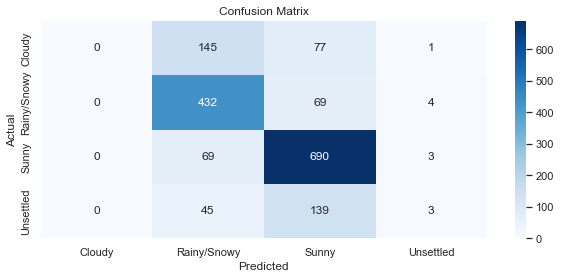

In [55]:
print("Testing Performance")
accuracy_lr, precision_lr, recall_lr, f1_lr = calculate_classification_metrics(y_test, y_pred_lr_new, "Logistic Regression")

## Gaussian Naive Bayes

In [56]:
# Hyperparameter tuning
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-10]}

if(best_model_nb == None):
    # Model Creation and Training
    model_nb = GaussianNB()
    models_nb = GridSearchCV(estimator=model_nb, param_grid=parameters, cv=4)
    models_nb.fit(x_train, y_train)
    best_parameters = models_nb.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on training data
    best_model_nb = models_nb.best_estimator_

y_pred_nb = best_model_nb.predict(x_train)
# Predictions on test data
y_pred_nb_new = best_model_nb.predict(x_test)
prob_pred_nb_new = best_model_nb.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_nb, y_test, y_pred_nb_new)

Model is underfitting.


Testing Performance
Algorithm:  Gaussian NB

Accuracy: 0.625
Precision: 0.559
Recall: 0.625
F1 Score: 0.569



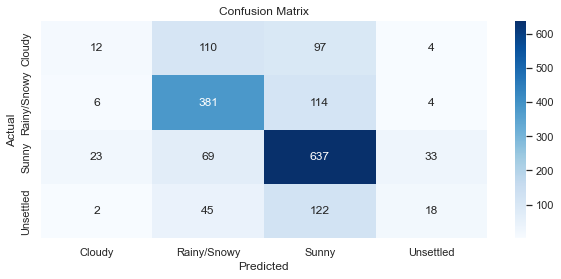

In [57]:
print("Testing Performance")
accuracy_nb, precision_nb, recall_nb, f1_nb = calculate_classification_metrics(y_test, y_pred_nb_new, "Gaussian NB")

## SVC

In [58]:
# Hyperparameter tuning
parameters = {'C':[0.001,0.01,0.0001, 0.1],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],}

if(best_model_svc == None):
    # Model Creation and Training
    model_svc = SVC(probability=True)
    models_svc = GridSearchCV(estimator=model_svc, param_grid=parameters, cv=4)
    models_svc.fit(x_train, y_train)
    best_parameters = models_svc.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on train data
    best_model_svc = models_svc.best_estimator_

y_pred_svc = best_model_svc.predict(x_train)
# Predictions on test data
y_pred_svc_new = best_model_svc.predict(x_test)
prob_pred_svc_new = best_model_svc.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_svc, y_test, y_pred_svc_new)

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  SVC

Accuracy: 0.667
Precision: 0.506
Recall: 0.667
F1 Score: 0.575



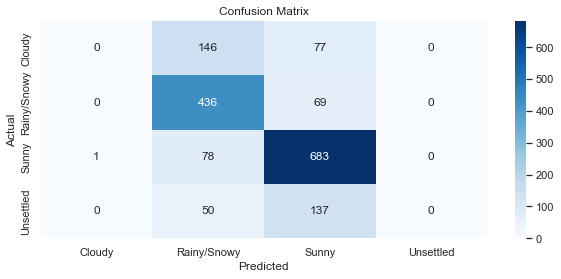

In [59]:
print("Testing Performance")
accuracy_svc, precision_svc, recall_svc, f1_svc = calculate_classification_metrics(y_test, y_pred_svc_new, "SVC")

## SGD Classifier

In [60]:
# Hyperparameter tuning
parameters = {'loss':['log_loss','perceptron','squared_epsilon_insensitive'],
              'penalty': ['l1', 'l2'],
              'alpha':[0.001,0.01,0.0001],
              'learning_rate':['optimal','adaptive','invscaling']}

if(best_model_sgd == None):
    # Model Creation and Training
    model_sgd = SGDClassifier()
    models_sgd = GridSearchCV(estimator=model_sgd, param_grid=parameters, cv=4)
    models_sgd.fit(x_train, y_train)
    best_parameters = models_sgd.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on train data
    best_model_sgd = models_sgd.best_estimator_

y_pred_sgd = best_model_sgd.predict(x_train)
# Predictions on test data
y_pred_sgd_new = best_model_sgd.predict(x_test)
prob_pred_sgd_new = best_model_sgd.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_sgd, y_test, y_pred_sgd_new)

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  SGD Classifier

Accuracy: 0.67
Precision: 0.534
Recall: 0.67
F1 Score: 0.58



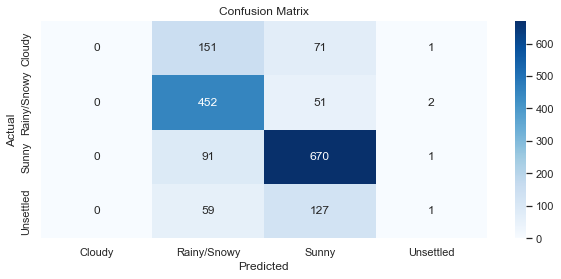

In [61]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = calculate_classification_metrics(y_test, y_pred_sgd_new, "SGD Classifier")

## Decision Tree Classifier

In [62]:
# Hyperparameter tuning
parameters = {'criterion':['gini', 'entropy', 'log_loss'], 
              'max_depth': [None, 5, 10],
              'min_samples_split': [None, 2, 5],
              'splitter':['best','random']}

if(best_model_dt == None):
    # Model Creation and Training
    model_dt = DecisionTreeClassifier()
    models_dt = GridSearchCV(estimator=model_dt, param_grid=parameters, cv=4)
    models_dt.fit(x_train, y_train)
    best_parameters = models_dt.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on train data
    best_model_dt = models_dt.best_estimator_
y_pred_dt = best_model_dt.predict(x_train)
# Predictions on test data
y_pred_dt_new = best_model_dt.predict(x_test)
prob_pred_dt_new = best_model_dt.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_dt, y_test, y_pred_dt_new)

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Decision Tree

Accuracy: 0.647
Precision: 0.488
Recall: 0.647
F1 Score: 0.556



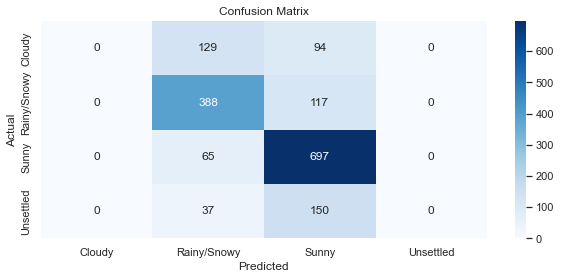

In [63]:
print("Testing Performance")
accuracy_dt, precision_dt, recall_dt, f1_dt = calculate_classification_metrics(y_test, y_pred_dt_new, "Decision Tree")

## KNN

In [64]:
# Hyperparameter tuning
parameters = {'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree','kd_tree','brute'],
            'p': [1,2]}

if(best_model_knn == None):
    # Model Creation and Training
    model_knn = KNeighborsClassifier(n_neighbors=5)
    models_knn = GridSearchCV(estimator=model_knn, param_grid=parameters, cv=4)
    models_knn.fit(x_train, y_train)
    best_parameters = models_knn.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on train data
    best_model_knn = models_knn.best_estimator_
y_pred_knn = best_model_knn.predict(x_train)
# Predictions on test data
y_pred_knn_new = best_model_knn.predict(x_test)
prob_pred_knn_new = best_model_knn.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_knn, y_test, y_pred_knn_new)

Model is overfitting.


Testing Performance
Algorithm:  KNN

Accuracy: 0.618
Precision: 0.588
Recall: 0.618
F1 Score: 0.601



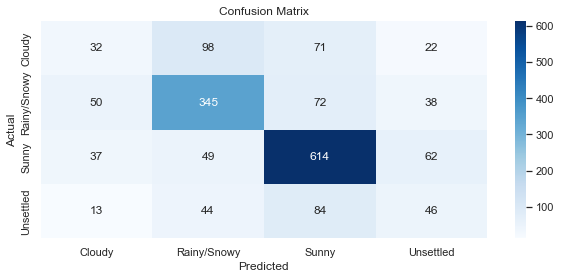

In [65]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_knn, precision_knn, recall_knn, f1_knn = calculate_classification_metrics(y_test, y_pred_knn_new, "KNN")

## Random Forest Classfier

In [66]:
# Hyperparameter tuning
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5]}

if(best_model_rf == None):
    # Model Creation and Training
    model_rf = RandomForestClassifier()
    models_rf = GridSearchCV(estimator=model_rf, param_grid=parameters, cv=4)
    models_rf.fit(x_train, y_train)
    best_parameters = models_rf.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on train data
    best_model_rf = models_rf.best_estimator_
    
y_pred_rf = best_model_rf.predict(x_train)
# Predictions on test data
y_pred_rf_new = best_model_rf.predict(x_test)
prob_pred_rf_new = best_model_rf.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_rf, y_test, y_pred_rf_new)

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Random Forest

Accuracy: 0.652
Precision: 0.595
Recall: 0.652
F1 Score: 0.569



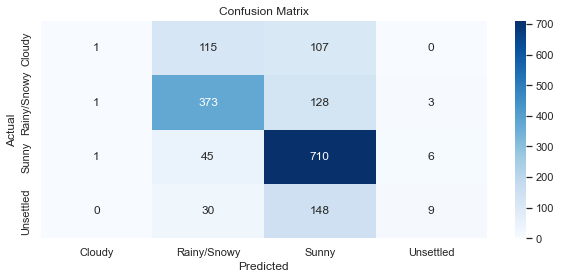

In [67]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_rf, precision_rf, recall_rf, f1_rf = calculate_classification_metrics(y_test, y_pred_rf_new, "Random Forest")

## Gradient Boosting

In [68]:
# Hyperparameter tuning
parameters = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

if(best_model_gb == None):
    # Model creation and training
    model_gb = GradientBoostingClassifier()
    models_gb = GridSearchCV(estimator=model_gb, param_grid=parameters, cv=4)
    models_gb.fit(x_train, y_train)
    best_parameters = models_gb.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions on the training data
    best_model_gb = models_gb.best_estimator_

y_pred_gb = best_model_gb.predict(x_train)
# Predictions on the test data
y_pred_gb_new= best_model_gb.predict(x_test)
prob_pred_gb_new = best_model_gb.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_gb, y_test, y_pred_gb_new)

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Gradient Boosting Classifier

Accuracy: 0.652
Precision: 0.5
Recall: 0.652
F1 Score: 0.559



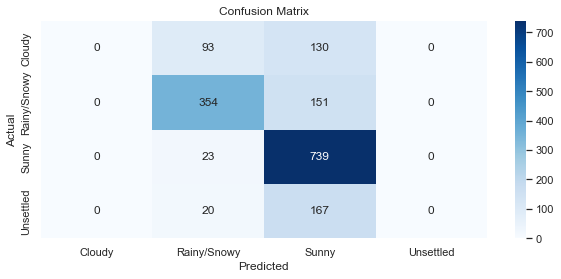

In [69]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_gb, precision_gb, recall_gb, f1_gb = calculate_classification_metrics(y_test, y_pred_gb_new, "Gradient Boosting Classifier")

## Bagging

In [70]:
# Hyperparameter tuning
parameters = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}

if(best_model_bagging == None):
    # Model creation and training
    model_bagging = BaggingClassifier()
    models_bagging = GridSearchCV(estimator=model_bagging, param_grid=parameters, cv=4)
    models_bagging.fit(x_train, y_train)
    best_parameters = models_bagging.best_params_
    print("Best Hyperparameters:", best_parameters)
    print()
    # Predictions for train
    best_model_bagging = models_bagging.best_estimator_

y_pred_bagging = best_model_bagging.predict(x_train)
# Predictions for test
y_pred_bagging_new= best_model_bagging.predict(x_test)
prob_pred_bagging_new = best_model_bagging.predict_proba(x_test)
checking_overfitting_undefitting(y_train, y_pred_bagging, y_test, y_pred_bagging_new)

Model is overfitting.


Testing Performance
Algorithm:  Bagging Classifier

Accuracy: 0.658
Precision: 0.613
Recall: 0.658
F1 Score: 0.604



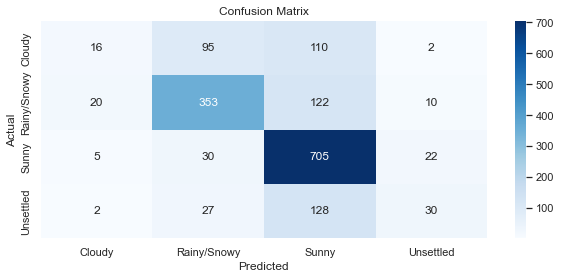

In [71]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_bc, precision_bc, recall_bc, f1_bc = calculate_classification_metrics(y_test, y_pred_bagging_new, "Bagging Classifier")

## Results

In [72]:
# Results
print("Testing Performances for Machine Learning Algorithms")
result = pd.DataFrame({"Algorithms":['Logistic Regression', "Gaussian Naive Bayes", "SVC", "SGD Classifier", "Decision Tree", "KNN","Random Forest", "Bagging Classifier","Gradient Boosting Classifier"],
                       "Accuracy":[accuracy_lr, accuracy_nb, accuracy_svc, accuracy_sgd, accuracy_dt, accuracy_knn, accuracy_rf, accuracy_bc, accuracy_gb],
                       "Precision":[precision_lr, precision_nb, precision_svc, precision_sgd, precision_dt, precision_knn, precision_rf, precision_bc, precision_gb],
                       "Recall":[recall_lr, recall_nb, recall_svc, recall_sgd, recall_dt, recall_knn, recall_rf, recall_bc, recall_gb],
                       "F1 Score":[f1_lr, f1_nb, f1_svc, f1_sgd, f1_dt, f1_knn, f1_rf, f1_bc, f1_gb]}).set_index('Algorithms')
result

Testing Performances for Machine Learning Algorithms


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
Logistic Regression,0.671,0.540,0.671,0.582
Gaussian Naive Bayes,0.625,0.559,0.625,0.569
SVC,0.667,0.506,0.667,0.575
SGD Classifier,0.670,0.534,0.670,0.580
Decision Tree,0.647,0.488,0.647,0.556
KNN,0.618,0.588,0.618,0.601
Random Forest,0.652,0.595,0.652,0.569
Bagging Classifier,0.658,0.613,0.658,0.604
Gradient Boosting Classifier,0.652,0.500,0.652,0.559


## Save Learned Models

In [73]:
# Saving sklearn machine learning models
models = [best_model_dt, best_model_lr, best_model_knn, best_model_nb, best_model_rf, best_model_sgd, best_model_svc, best_model_gb, best_model_bagging]
names = ["dt","lr","knn","nb","rf","sgd","svc","gb","bg"]
for i in range(len(models)):
    joblib.dump(models[i],names[i]+".pkl")

## Base Line
In comparison to check whether the classifiers are actually doing something, we check the base rates for the different weather classes.

In [74]:
base_rates = data["Weather"].value_counts(sort=False, ascending=True).values[np.array([-1,0,1,2])] / data["Weather"].value_counts().values.sum()
y_pred_bl_new = np.random.choice(np.arange(4), size=len(x_test), p=base_rates)
#prob_pred_bl_new = 

In [75]:
data["Weather"].value_counts(sort=False, ascending=True).values[np.array([-1,0,1,2])]

array([1082, 2657, 3747,  900])

In [76]:
data["Weather"].value_counts(sort=False, ascending=True)

1    2657
2    3747
3     900
0    1082
Name: Weather, dtype: int64

Testing Performance
Algorithm:  Base-rate Classifier

Accuracy: 0.323
Precision: 0.327
Recall: 0.323
F1 Score: 0.325



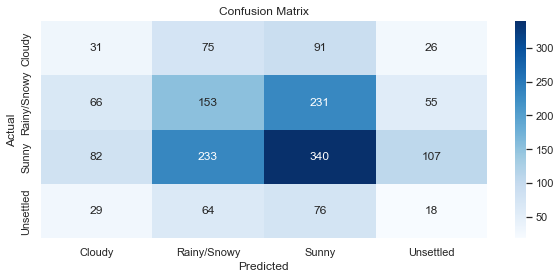

In [77]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_bl, precision_bl, recall_bl, f1_bl = calculate_classification_metrics(y_test, y_pred_bl_new, "Base-rate Classifier")

# Weather-AA

In [78]:
act_prob_pred_lr_new = prob_pred_lr_new[np.arange(len(y_test)), y_test]
act_prob_pred_nb_new = prob_pred_nb_new[np.arange(len(y_test)), y_test]
act_prob_pred_svc_new = prob_pred_svc_new[np.arange(len(y_test)), y_test]
act_prob_pred_sgd_new = prob_pred_sgd_new[np.arange(len(y_test)), y_test]
act_prob_pred_dt_new = prob_pred_dt_new[np.arange(len(y_test)), y_test]
act_prob_pred_knn_new = prob_pred_knn_new[np.arange(len(y_test)), y_test]
act_prob_pred_rf_new = prob_pred_rf_new[np.arange(len(y_test)), y_test]
act_prob_pred_gb_new = prob_pred_gb_new[np.arange(len(y_test)), y_test]
act_prob_pred_bagging_new = prob_pred_bagging_new[np.arange(len(y_test)), y_test]

# collecting expert's prediction
expertsPred = np.array([act_prob_pred_lr_new,
                        act_prob_pred_nb_new,
                        act_prob_pred_svc_new,
                        act_prob_pred_sgd_new,
                        act_prob_pred_dt_new,
                        act_prob_pred_knn_new,
                        act_prob_pred_rf_new,
                        act_prob_pred_gb_new,
                        act_prob_pred_bagging_new]).T

E = len(expertsPred[0])
expertsPred.shape

In [79]:

# collecting expert's prediction
expertsPred = np.array([prob_pred_lr_new,
                        prob_pred_nb_new,
                        prob_pred_svc_new,
                        prob_pred_sgd_new,
                        prob_pred_dt_new,
                        prob_pred_knn_new,
                        prob_pred_rf_new,
                        prob_pred_gb_new,
                        prob_pred_bagging_new])

expertsPred.shape #  (#experts, #instances, #outcomes)
E = expertsPred.shape[0]

In [80]:
E

9

In [81]:
# !!! IMPORTANT THE FUNCTION MUST WORK WITH NUMPYARRAY !!!


# Loss functions
# The input "datum" is a number from {0,1,2,3}.
# The input "prediction" is an array of the shape (#experts,#outcomes)

def logloss(datum,prediction):
    return -np.log(prediction[:,datum])

def logloss05(datum,prediction):
    return -0.5*np.log(prediction[:,datum])

def log2loss05(datum, prediction):
    return 0.5*np.log(prediction[:,datum])**2

def log2loss1(datum, prediction):
    return np.log(prediction[:,datum])**2

#def brierloss(datum, prediction):
#    return np.square(datum - prediction)

gamma = 2
def focalloss(datum, prediction):
    return -(1-prediction[:,datum])**gamma * np.log(prediction[:,datum])

def focalloss05(datum, prediction):
    return -0.5*(1-prediction[:,datum])**gamma * np.log(prediction[:,datum])

def log05loss1(datum, prediction):
    return np.abs(np.log(prediction[:,datum]))**0.5

def log05loss2(datum, prediction):
    return 2*np.abs(np.log(prediction[:,datum]))**0.5

def log10loss0001(datum, prediction):
    return 0.001*np.abs(np.log(prediction[:,datum]))**10

def log10loss0000001(datum, prediction):
    return 0.000001*np.abs(np.log(prediction[:,datum]))**10

In [82]:
def normalize_points(points):
    return points / points.sum(axis=1, keepdims=True)

def generate_grid(n_points):
    points = np.linspace(0, 1, n_points)
    meshgrids = np.meshgrid(*[points] * 4, indexing='ij')

    grid_points = np.vstack([x.flatten() for x in meshgrids]).T
    grid_points = grid_points[grid_points.sum(axis=1) <= 1]

    return grid_points

# Define the number of points along each axis
n_points = 30

# Generate the grid
grid_points = generate_grid(n_points)
normalized_points = normalize_points(grid_points)

# Remove duplicates
unique_points, indices = np.unique(normalized_points, axis=0, return_index=True)

print("Number of unique points in the simplex grid:", len(unique_points))
#print("Example unique points (normalized):")
#for point in unique_points:
#    print(point)

Number of unique points in the simplex grid: 37353


In [83]:
# MIXABILITY FUNCTIONS

eta = 1.0 # learning rate


# standard
def standard(xs):
    return np.exp(-eta*xs)

def standardinv(xs):
    return (-1/eta)*np.log(xs)

f = standard
g = standardinv

In [84]:
grid = unique_points[:-1] # to remove the nan

# The Aggregating Algorithm

In [85]:
losses_f = []
losses_AA_f = []
preds_f = []
weights_f = []

for lossf in [logloss, log2loss05, log05loss2, log10loss0001, focalloss]:
#[logloss, logloss05, log2loss05, log2loss1, focalloss, focalloss05, log05loss2, log10loss0001, log10loss0000001]:
    # INITIALIZATION
    P0 = np.ones(E) / E #np.array([0.01, 0.01, 0.96, 0.01, 0.01]) #initial distribution on experts
    P_t_1 = P0
    weights = [P0]

    losses = [] # only the experts
    losses_AA = [] # loss of the AA
    preds = []

    for (t, datum) in enumerate(y_test):
        # EXPERTS PREDICTIONS
        expertsPred_t = expertsPred[:,t,:]

        # WEIGHT UPDATING
        # here in the step the np.exp(-eta ...) should be replaced by f for the generalized version of the AA
        P_t = f(lossf(datum, expertsPred_t)) * P_t_1
        P_t = P_t / np.sum(P_t)
        weights.append(P_t)

        # PREDICTION
        # the np.log here should be replaced by g for the generalizaed AA
        # definition of a function (if we really want to implement a generalized prediction)
        # genPred(DATUM) = np.log(np.sum(np.exp(- eta * lossf(DATUM, experts[i])) * Pt_1[i]))/np.log(np.exp(-eta))
        # brute force in our case is simple just calculate the function for the two values {0,1}
        genPred0 = g(np.sum(f(lossf(0, expertsPred_t)) * P_t_1))
        genPred1 = g(np.sum(f(lossf(1, expertsPred_t)) * P_t_1))
        genPred2 = g(np.sum(f(lossf(2, expertsPred_t)) * P_t_1))
        genPred3 = g(np.sum(f(lossf(3, expertsPred_t)) * P_t_1))

        # SUBSTITUTION OF PREDICTION
        # search gamma which minimizes:
        # np.max(lossf(0, grid)/genPred(0), lossf(1, grid)/genPred(1))
        # we do it the bruteforce way and just calculate the function at many values betweenon the 4dim simplex
        i = np.argmin(np.maximum(np.maximum(np.log(f(lossf(0, grid)))/np.log(f(genPred0)),
                                            np.log(f(lossf(1, grid)))/np.log(f(genPred1))),
                                 np.maximum(np.log(f(lossf(2, grid)))/np.log(f(genPred2)),
                                            np.log(f(lossf(3, grid)))/np.log(f(genPred3)))))

        pred_t = grid[i]
        preds.append(pred_t)

        # CALCULATING LOSSES
        losses.append(logloss(datum, expertsPred_t))
        losses_AA.append(logloss(datum, np.expand_dims(pred_t,axis=0)))


        # RECURSIVE DEFINITIONS
        P_t_1 = P_t

    losses = np.array(losses)
    losses_AA = np.array(losses_AA)
    preds = np.array(preds)
    weights = np.array(weights)

    losses_f.append(losses)
    losses_AA_f.append(losses_AA)
    preds_f.append(preds)
    weights_f.append(weights)

In [86]:
losses_f = np.array(losses_f)
losses_AA_f = np.array(losses_AA_f)
preds_f = np.array(preds_f)
weights_f = np.array(weights_f)

In [87]:
weights_f[0].shape

(1678, 9)

0


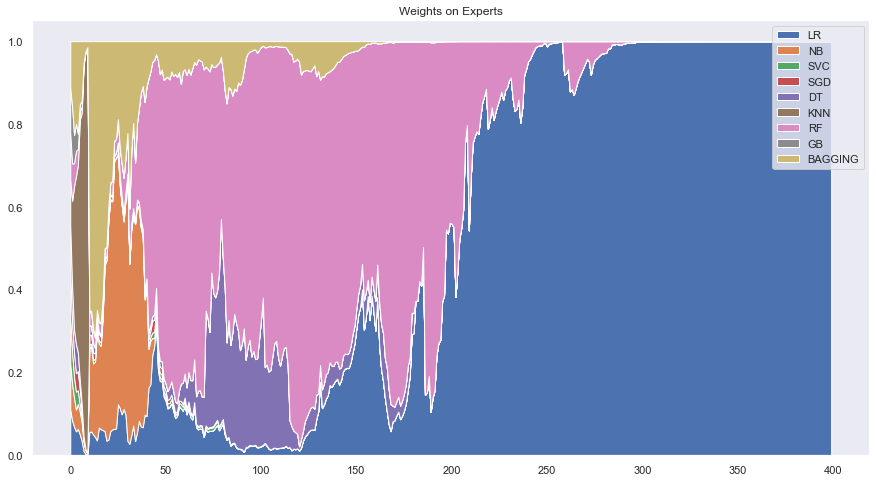

1


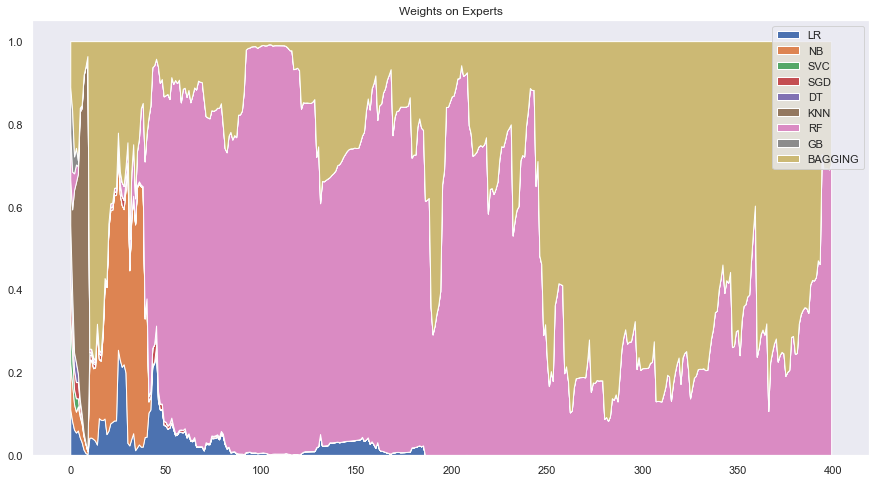

2


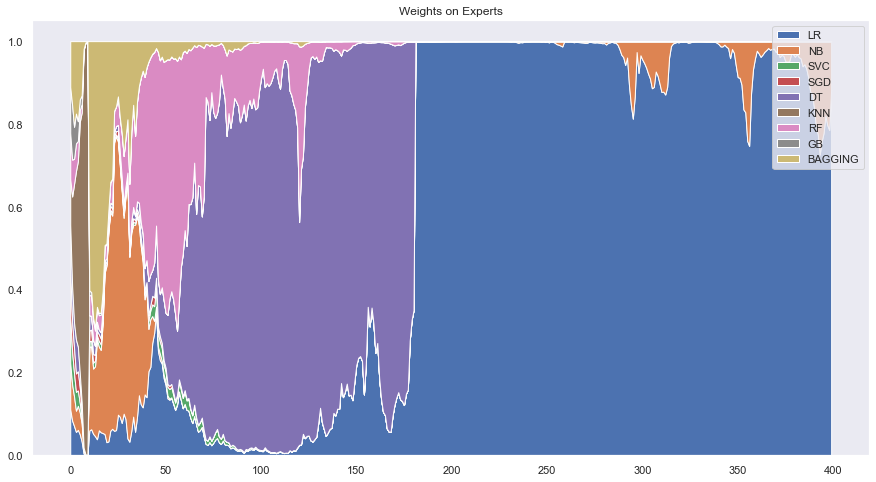

3


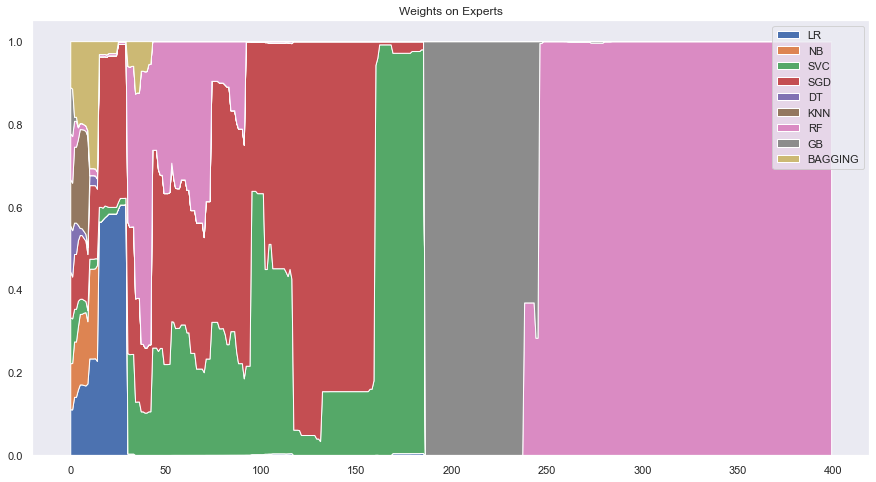

4


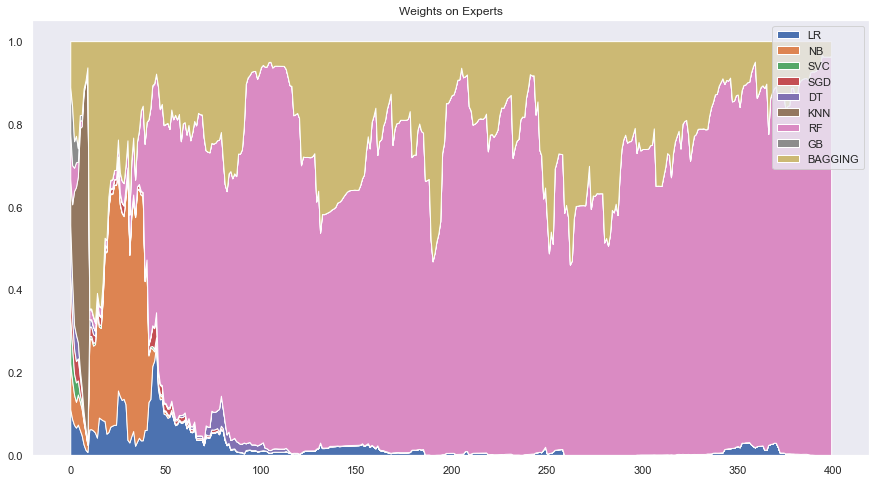

In [88]:
# WEIGHTS ON EXPERTS

N = 400#len(y_test)

for i in np.arange(weights_f.shape[0]):
    print(i)

    labels = ["LR", "NB", "SVC", "SGD", "DT", "KNN", "RF", "GB", "BAGGING"]

    fig, ax = plt.subplots(figsize=(15,8))
    #ax.set(xlim=(0, N), ylim=(0, 100))

    ax.stackplot(np.arange(N), weights_f[i,:N,:].T, labels=labels)
    ax.set_title("Weights on Experts")
    ax.legend(loc="upper right")
    #plt.savefig("weights" + mixabFunc + "_" + str(eta) + ".png")
    plt.show()

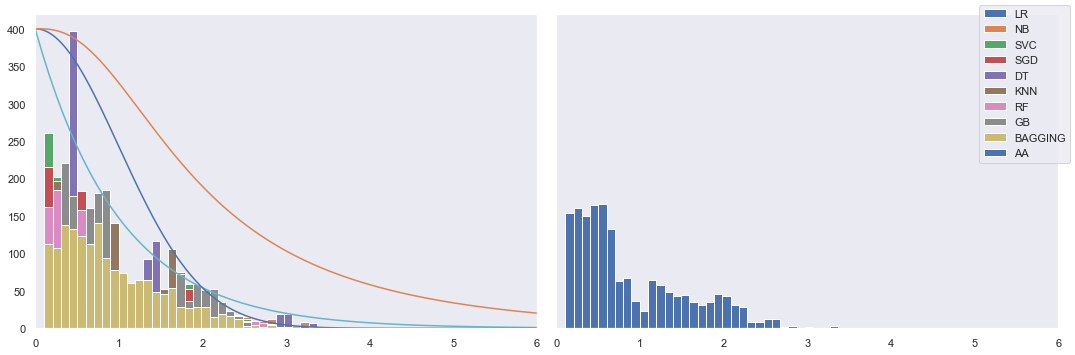

In [89]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(15,5))


bins = np.histogram(losses_AA_f, bins="auto", range=(0.0, 3.4))[1]

loss_dists = losses_f[0]

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(loss_dists[:,0], label="LR", bins=bins)
axs[0].hist(loss_dists[:,1], label="NB", bins=bins)
axs[0].hist(loss_dists[:,2], label="SVC", bins=bins)
axs[0].hist(loss_dists[:,3], label="SGD", bins=bins)
axs[0].hist(loss_dists[:,4], label="DT", bins=bins)
axs[0].hist(loss_dists[:,5], label="KNN", bins=bins)
axs[0].hist(loss_dists[:,6], label="RF", bins=bins)
axs[0].hist(loss_dists[:,7], label="GB", bins=bins)
axs[0].hist(loss_dists[:,8], label="BAGGING", bins=bins)
axs[1].hist(losses_AA, label="AA", bins=bins)


x_lim = 6
axs[0].set_xlim(0,x_lim)
axs[1].set_xlim(0,x_lim)

# standard weighting profile
xs = np.linspace(0,x_lim, 1000)
ys_std = 400*np.exp(-xs)
axs[0].plot(xs, ys_std)
# sqaured weighting profile
ys_sqw = 400*np.exp(-0.5*xs**2)
axs[0].plot(xs, ys_sqw)
# focal weighting profile
gamma = 2
ys_fw = 400*np.exp(-0.5*(1-np.exp(-xs))**gamma * xs)
axs[0].plot(xs, ys_fw)

fig.legend()

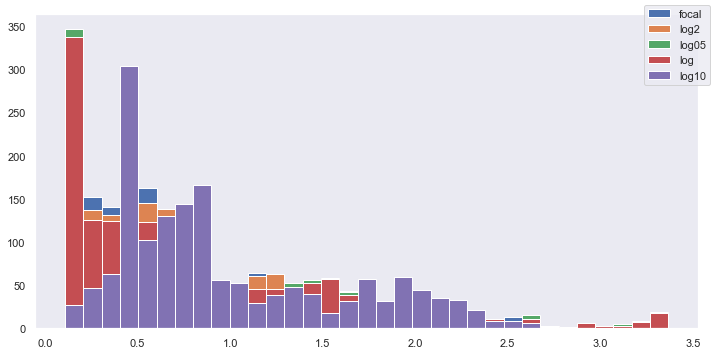

In [90]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True, figsize=(10,5))
N=1600

#ATTENTION IF LONG LOSS FUNCTION ARRAY
#[logloss, logloss05, log2loss05, log2loss1, focalloss, focalloss05, log05loss2, log10loss0001, log10loss0000001]
axs.hist(losses_AA_f[4,:N,0], label="focal", bins=bins)


axs.hist(losses_AA_f[1,:N,0], label="log2", bins=bins)

axs.hist(losses_AA_f[2,:N,0], label="log05", bins=bins)
axs.hist(losses_AA_f[0,:N,0], label="log", bins=bins)
axs.hist(losses_AA_f[3,:N,0], label="log10", bins=bins)
#axs.set_xlim(0,100)
#axs.set_yscale('log')
fig.legend()
fig.show()

# Plots of Loss Histogram

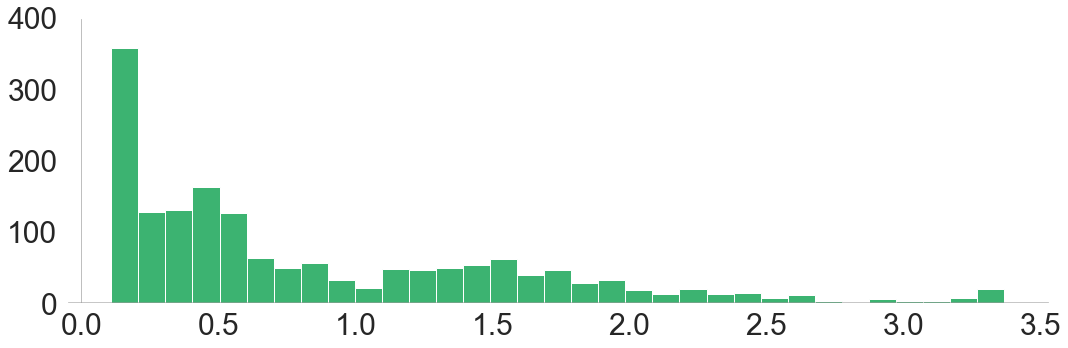

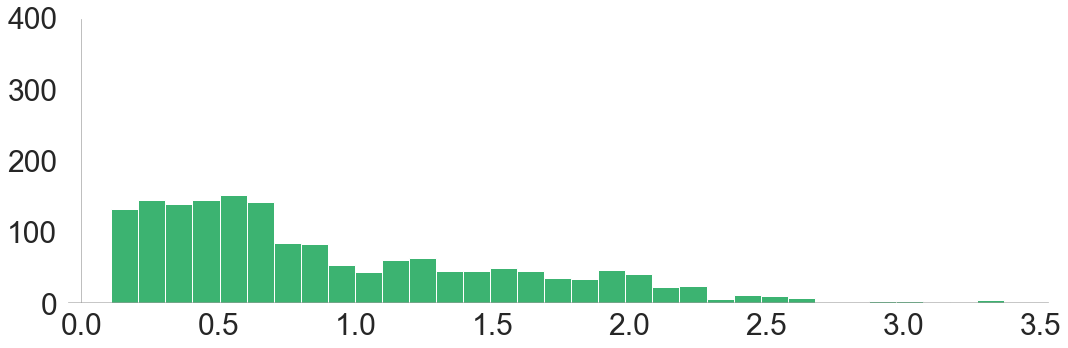

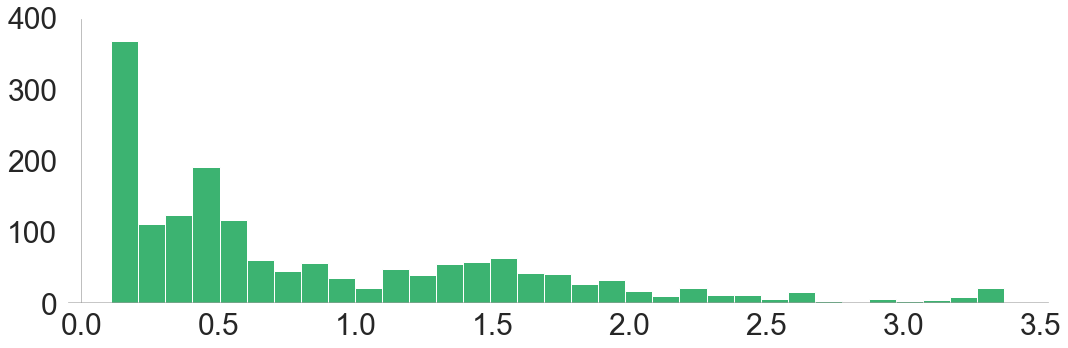

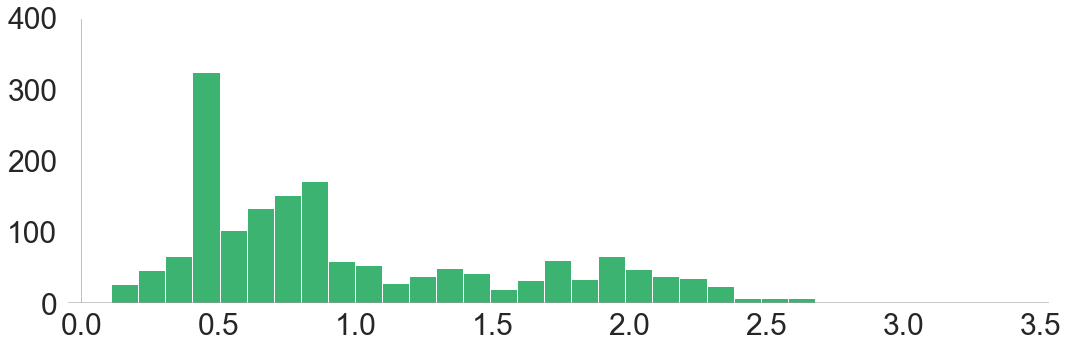

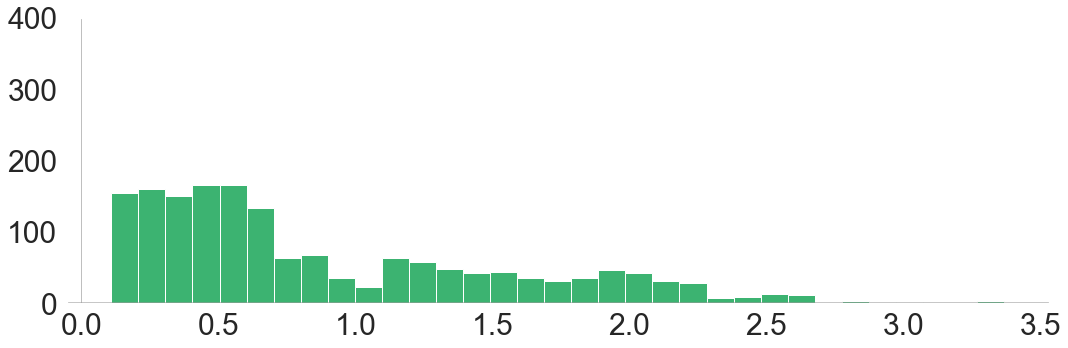

In [100]:
colors = ["lightseagreen", "limegreen", "mediumseagreen", "seagreen", "darkgreen", "darkslategray"]
#[logloss, log2loss, log05loss, log10loss, focalloss]
#[logloss, logloss05, log2loss05, log2loss1, focalloss, focalloss05, log05loss2, log10loss0001, log10loss0000001]
permut = np.array([1,2,0,3,4])

usedlossfuncs = ["log1", "log2", "log05", "log10", "focal"]

for i in range(losses_AA_f.shape[0]):
    fig = plt.figure(tight_layout=True, figsize=(15,5))
    plt.hist(losses_AA_f[i,:,0],bins=bins, color=colors[permut[1]])
    plt.gca().set_ylim((0,400))
    plt.axvline(0, color='grey', linewidth=0.5) 
    plt.axhline(2, color='grey', linewidth=0.5) 
    plt.gca().set_facecolor('white')
    plt.tick_params(axis='both', which='major', labelsize=30)
    if np.isinf(losses_AA_f[i]).sum() > 0:
        plt.bar(3.4 + (bins[1]-bins[0])/2, np.isinf(losses_AA_f[i]).sum(), width=bins[1]-bins[0], label="$\infty$")
        plt.legend(fontsize=30)
    #axs.set_xlim(0,100)
    #axs.set_yscale('log')
    plt.savefig("Loss histograms_Neurips/losshisto_" + usedlossfuncs[i] + ".png")
    plt.show()

Copyright [2024] [Rabanus Derr]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.